In [1]:
import cv2 as cv
import numpy as np
import os
import shutil
import torch
import random
import torchvision
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt
from PIL import Image, ImageOps, ImageEnhance
from torchvision.transforms import functional as F

from torch import nn
from tqdm import tqdm
from io import BytesIO

#Para solucionar un posible problema con plt
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Empezamos recortando las imagenes del dataset por el centroide de la figura

In [2]:
def filter_image(image, debug = 0):
    #Pasamos la imagen a una escala de grises
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    #Aplicamos un filtro gausiano para eliminar ruido
    blur = cv.GaussianBlur(gray, (5, 5), 0)
    #Convertimos la imagen a blanco y negro
    ret, thresh = cv.threshold(blur, 75, 255, cv.THRESH_BINARY_INV)
    #Mostramos la imagen si es necesario
    if debug != 0:
        cv.imwrite("filter.png", thresh)
    return ret, thresh

def centroid(image, debug = 0):
    #Encontramos todos los contornos
    contours, hierarchies = cv.findContours(image, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)

    if len(contours) != 0:  
        #Escogemos el contorno con mayor area
        c = max(contours, key = cv.contourArea)
        #Realizamos el cálculo de los centroides
        M = cv.moments(c)
        if M['m00'] != 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            if debug != 0:
                print(f"x: {cx} y: {cy}")
    return cx, cy

In [3]:
def crop(path, new_path, type):
    i = 0
    for item in os.listdir(path):
        if os.path.isfile(os.path.join(path, item)):
            image = cv.imread(os.path.join(path, item))
            if image is not None:
                ret, thresh = filter_image(image)
                cx, cy = centroid(thresh)
                w = 215
                imageOut = image[cy-w:cy+w+1, cx-w:cx+w+1]
                #Renombramos los archivos
                name = str(i) + "_" + type + ".png"
                i = i + 1
                try:
                    cv.imwrite(os.path.join(new_path, name), imageOut)
                except:
                    continue

In [4]:
no_fail_path = "Dataset/Original/Sin Fallo"
fail_path = "Dataset/Original/Con Fallo"

new_no_fail_path =  "Dataset/Cortado/Sin Fallo"
new_fail_path =  "Dataset/Cortado/Con Fallo"

if os.path.exists(new_no_fail_path): shutil.rmtree(new_no_fail_path)
os.makedirs(new_no_fail_path)

if os.path.exists(new_fail_path): shutil.rmtree(new_fail_path)
os.makedirs(new_fail_path)

crop(no_fail_path, new_no_fail_path, "nofail")
crop(fail_path, new_fail_path, "fail")

## Preparando el dataset para el entrenamiento de la red
Comprobamos si disponemos de una GPU con cuda, en caso afirmativo la asignamos como dispositivo, de lo contrario el dispositivo predetermiando será la CPU

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Definimos una función para dividir el dataset de forma aleatoria entre dos partes

In [6]:
def split_data(dataset, test_size):
    L = len(dataset)
    n_second = int(L*test_size)
    n_first = L - n_second
    first_split, second_split = random_split(dataset, lengths=[n_first, n_second])
    return first_split, second_split

Establecemos la ruta en la que se encuentra el dataset y lo dividimos en entrenamiento (80%) y validación (20%), el dataset de pruebas será un 10% del dataset calculado para el entrenamiento

In [13]:
DATASET_PATH = "Dataset/Cortado"
dataset = torchvision.datasets.ImageFolder(DATASET_PATH)

training_dataset, validation_dataset = split_data(dataset, test_size = 0.2)
training_dataset, test_dataset = split_data(training_dataset, test_size = 0.1)

print('Data for trainig: {}'.format(len(training_dataset)))
print('Data for validation: {}'.format(len(validation_dataset)))
print('Data for testing: {}'.format(len(test_dataset)))

Data for trainig: 2205
Data for validation: 612
Data for testing: 245


Definimos una clase que nos permite obtener elementos del dataset

In [8]:
class SubsetTransforms(Dataset):
    def __init__(self, subset, transforms):
        self.subset = subset
        self.transforms = transforms
        
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        return self.transforms(x), y

    def __len__(self):
        return len(self.subset)

Definimos el método show, para posteriormente poder mostrar un ejemplo visual del contenido del dataset

In [9]:
def show(dataset, N=5, labels=None, figsize=(20, 20)):
    idxs = np.random.randint(0, len(dataset)-1, N)
    fig, axs = plt.subplots(ncols=len(idxs), squeeze=False, figsize=figsize)

    for i, idx in enumerate(idxs):
        sample = dataset[idx]
        if isinstance(sample, tuple): # Si el primer argumento forma parte del segundo
            sample, label = sample
            if isinstance(label, torch.TensorType):
                label = int(label.item())
            if labels:
                label = labels[label]
            axs[0, i].title.set_text(label)
        axs[0, i].imshow(F.to_pil_image(sample))
        axs[0, i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])

    plt.show()

Configurmos el tamaño del batch y realizamos técnicas de Data Augmentation mediante transformaciones (ajustes de tamaño, rotaciones, giros) para posteriormente convertir a tensor y normalizar, finalmente, se configuran los cargadores de datos de entrenamiento, validación y prueba.

In [10]:
batch_size = 32

transform = transforms.Compose([
                                transforms.Resize((200,200)),
                                transforms.RandomRotation(15),
                                transforms.RandomHorizontalFlip(30),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
                               ])

training_dataset = SubsetTransforms(training_dataset, transform)
test_dataset = SubsetTransforms(test_dataset, transform)
validation_dataset = SubsetTransforms(validation_dataset, transform)

train_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

Mostramos un ejemplo de 5 imágenes aleatorias del dataset de entrenamiento

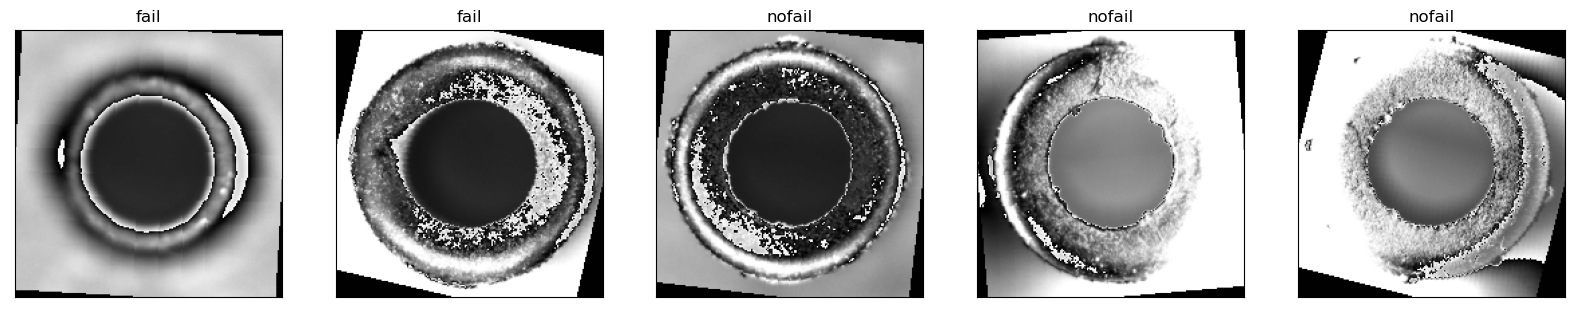

In [11]:
labels_to_idx = {"nofail":1, "fail":0}
idx_to_labels = {0: "fail", 1: "nofail"}

show(training_dataset, labels=idx_to_labels)

## Definimos las funciones para realizar el entrenamiento, validación y test de los diferentes modelos

In [12]:
def train(epoch, model, optimizer, criterion, log_interval=200):
    #Ponemos el modelo en modo entrenamiento
    model.train()
    
    #Para cada lote del dataset de entrenamiento
    for batch_idx, (data, target) in enumerate(train_loader):
        #Llevamos los datos al dispositivo disponible (GPU/CPU)
        data = data.to(device)
        target = target.to(device)
        #Gradientes a cero (mejora de rendimiento)
        optimizer.zero_grad() 
        #Pasamos los datos a traves de la red
        output = model(data)
        #Calculamos la perdida
        loss = criterion(output, target)
        #Realizamos el paso atrás
        loss.backward()
        #Actualizamos los pesos
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [13]:
def validate(loss_vector, accuracy_vector, model, criterion):
    #Ponemos el modelo en modo evaluación
    model.eval()
    val_loss, correct = 0, 0
    
    #Para todo el dataset de validacción
    for data, target in validation_loader:
        #Llevamos los datos al dispositivo disponible (GPU/CPU)
        data = data.to(device)
        target = target.to(device)
        #Pasamos los datos a traves de la red
        output = model(data)
        #Calculamos e incrementamos la peridida de validación
        val_loss += criterion(output, target).data.item()
        #Obtenemos la prediccción del dato (la mayor clase)
        pred = output.data.max(1)[1]
        #Si la predicccioón es correcta, aumentamos el acierto
        correct += pred.eq(target.data).cpu().sum()
    #Añadimos los resultados al vector de perdidas
    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)
    #Añadimos los resultados al vector de aciertos
    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))

In [14]:
def test(model):
    #Ponemos el modelo en modo evaluación
    model.eval()
    correct = 0
    total = 0

    #Como no estamos entrenando, desactivamos los gradientes para mejorar el rendimiento
    with torch.no_grad():
        #Para todo el dataset de prueba
        for data in test_loader:
            images, labels = data
            #Pasamos los datos a traves de la red
            outputs = model.cpu()
            outputs = model(images)
            #Escogemos la predicción (la mayor clase)
            _, predicted = torch.max(outputs.data, 1)
            #Calculamos los resultados de las predicciones
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    print(f'Accuracy of the network on the test images: {100 * correct // total}%')

## Creamos dos modelos de red diferentes: 
### ResNet18
Aprovechando el transfer learrning tomamos un modelo de ResNet18 ya pre-entrenado, a este modelo se le añade una última capa lineal para que se ajuste a nuestro situación (solamente tenemos dos clases de salida), además re-entrenamos la capa 4 que hará que nuestra red se ajuste mejor a nuestro problema y entrenamos la última capa que acabamos de añadir, esto se consigue facilmente desactivando los gradientes del resto de capa que no necesitan entrenamiento.

In [15]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(512, 2)
        #Solo entrenamos las capas definidas en unfreeze
        unfreeze = ['layer4', 'fc']
        for layer_name, layer in self.model.named_parameters():
            for name in unfreeze:
                if name in layer_name:
                    layer.requires_grad = True
                    break
                else:
                    layer.requires_grad = False
    
    def forward(self, x):
        return self.model(x)

### MyNet
A continuación definimos otro modelo de red. Va a contar con 3 capas de convolucionales con función de activación RELU y Batch Normalization, posteriormente 3 capas ocultas full connected, todas ellas cuentan con una función de activación RELU, ademas ceunta con una función de dropout con una probabilidad del 35%.

In [16]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(256,512)
        self.dropout = nn.Dropout(0.35)
        self.fc2 = nn.Linear(512,128)
        self.fc3 = nn.Linear(128,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x): 
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1) #Recolocamos el tensor en una sola dimensión
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.relu(self.fc2(out)) #Última capa con 2 salidas correspondientes a las dos clases posibles
        out = self.fc3(out)
        
        return out

Cargamos el modelo y optimizador para los dos modelos definidos

In [17]:
my_model = MyNet().to(device)
my_model_optimizer = torch.optim.Adam(my_model.parameters(), lr=2e-4, betas=(0.9, 0.999), eps=1e-8)

resnet_model = ResNet().to(device)
resnet_optimizer = torch.optim.Adam(resnet_model.parameters(), lr=2e-4, betas=(0.9, 0.999), eps=1e-8)

#Será la misma para los dos modelos
criterion = nn.CrossEntropyLoss()

#print(my_model)
#print(resnet_model)

MyNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (dropout): Dropout(p=0.35, inplace=False)
  (fc2): Linear(in_features=512, out_features=128, bias=True

## Entrenamiento de los modelos
Realizamos el entrenamiento de la red "MyNet" durante 10 épocas mediante las funciones anteriormente definidas "train" y "validate", posteriormente realizamos un test del modelo con datos que la red nunca antes ha visto, guardamos el modelo y graficamos los resultados

Train Epoch: 1 [0/2205 (0%)]	Loss: 0.661786

Validation set: Average loss: 0.1182, Accuracy: 582/612 (95%)

Train Epoch: 2 [0/2205 (0%)]	Loss: 0.126273

Validation set: Average loss: 0.0828, Accuracy: 599/612 (98%)

Train Epoch: 3 [0/2205 (0%)]	Loss: 0.111349

Validation set: Average loss: 0.0659, Accuracy: 600/612 (98%)

Train Epoch: 4 [0/2205 (0%)]	Loss: 0.022035

Validation set: Average loss: 0.0664, Accuracy: 601/612 (98%)

Train Epoch: 5 [0/2205 (0%)]	Loss: 0.013799

Validation set: Average loss: 0.0597, Accuracy: 603/612 (99%)

Train Epoch: 6 [0/2205 (0%)]	Loss: 0.004906

Validation set: Average loss: 0.0581, Accuracy: 604/612 (99%)

Train Epoch: 7 [0/2205 (0%)]	Loss: 0.204939

Validation set: Average loss: 0.0624, Accuracy: 603/612 (99%)

Train Epoch: 8 [0/2205 (0%)]	Loss: 0.112561

Validation set: Average loss: 0.0993, Accuracy: 593/612 (97%)

Train Epoch: 9 [0/2205 (0%)]	Loss: 0.030114

Validation set: Average loss: 0.0550, Accuracy: 604/612 (99%)

Train Epoch: 10 [0/2205 (0%)

Text(0.5, 1.0, 'validation accuracy')

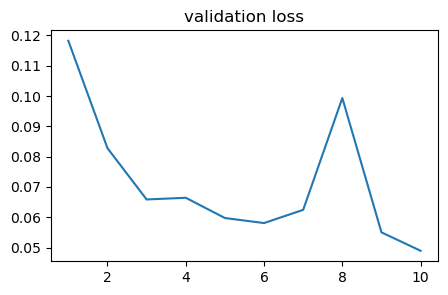

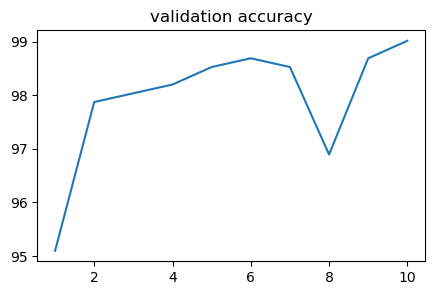

In [18]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch, my_model, my_model_optimizer, criterion)
    validate(lossv, accv, my_model, criterion)
test(my_model)
torch.save(my_model, 'my_model.pt')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv, label='loss')
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy')

Realizamos el entrenamiento de la red "ResNet18" durante 10 épocas mediante las funciones anteriormente definidas "train" y "validate", posteriormente realizamos un test del modelo con datos que la red nunca antes ha visto, guardamos el modelo y graficamos los resultados

In [ ]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch, resnet_model, resnet_optimizer, criterion)
    validate(lossv, accv, resnet_model, criterion)
test(resnet_model)
torch.save(resnet_model, 'resnet_model.pt')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv, label='loss')
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy')

### Realizamos una prueba visual, con 5 imagenes aleatorias del dataset de entrenamiento

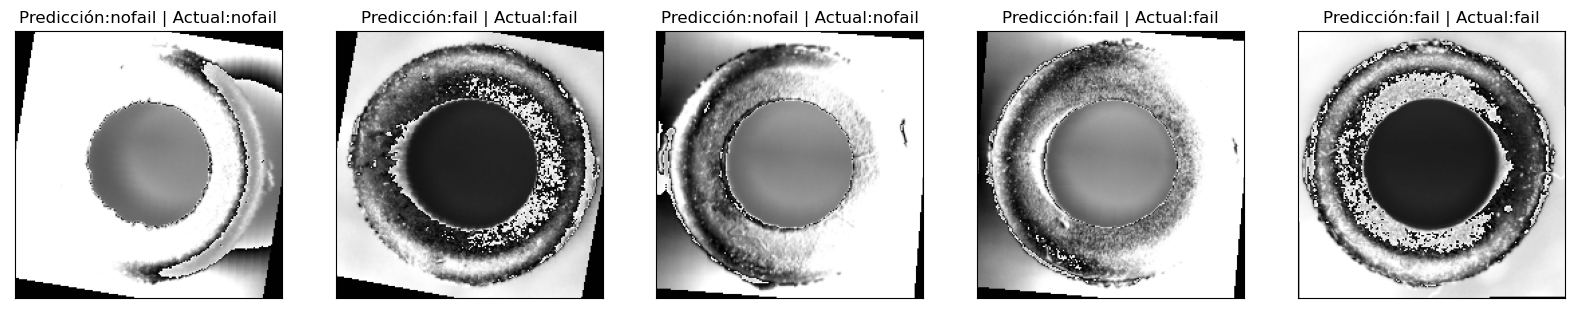

In [21]:
N=5
random_indices = np.random.randint(0, len(test_dataset)-1, N)
random_samples = [test_dataset[i] for i in random_indices]

fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20,20))

for i in range(N):
    sample = random_samples[i]
    image, label = sample
    category = idx_to_labels[label]
    
    input_image = image.unsqueeze(0)
    model=my_model.cpu()
    model_output = model(input_image)
    prediction = torch.argmax(torch.softmax(model_output, -1)).item()
    predicted_category = idx_to_labels[prediction]
    
    axs[i].imshow((image.permute(1, 2, 0) * 255).numpy().astype(np.uint8))
    axs[i].set(xticks=[], yticks=[], xticklabels=[], yticklabels=[])
    axs[i].set_title(f'Predicción:{predicted_category} | Actual:{category}')
plt.show()